# Drafting a Figure 3

__Jonah Shaw, 2022/03/04__

Observations show large increases in spring OLR despite the largest temperature increases occurring in the spring. We ask, is observed spring OLR consistent with variability present in the CESM1-LE?

Despite the OLR increases being concentrated in spectral bands heavily weighted towards the surface, we have to use broadband values if we want to compare with the model. This might muddy the signal if there is variability to do other climate processes (SSW events in the late winter).

_I will:_  

1) Plot observed OLR from CERES and AIRS, as well as AIRS spectral bands associated with the spring OLR changes that we are investigating. If I want I could also plot observed OLR just without CO2 bands from AIRS, and a fabricated CERES-AIRS value (subtract AIRS CO2 band values from the CERES OLR).

2) Add the OLR from this period from the CESM1-LE ensemble mean.

3) Add individual OLRs from each member of the CESM1-LE.

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, gridspec, ccrs, 
    Iterable, cmaps, glob, copy
    )

from functions import (
    masked_average, add_weights, leap_year,
    to_png, stats, MidpointNormalize, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define functions

#### Let's focus on the central Arctic for now (70-90N)

In [2]:
def arc_subset(*paths,var,chunks=None):
    '''
    Takes paths to several GCM outputs that are adjacent in time. Concatentates files and then 
    - subsets for time period 2001-2020.
    - subsets for the Arctic (lat > 70N)
    - dechunks (
    
    return subsetted data
    '''    
    
    # print(paths)

    # if len(paths) == 1:
    #     _ds_i = xr.open_dataset(*paths,chunks=chunks) # is this a good idea?
    # else:
    #     _ds_i = xr.open_mfdataset(paths,chunks=chunks)
    _ds_i = xr.open_mfdataset(paths,chunks=chunks)
        

    # Apparently this fix is bad for my preprocessed data?
    # subset = fix_cesm_time(_ds_i)[var].sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None))       
    subset = _ds_i[var].sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None))
    _ds_i.close()
    
    return subset

In [3]:
def is_jfm(times):
    '''
    Function to use with xarray.sel to grab only January, February and March
    '''
    
    jfm = [1,2,3]
    
    return np.isin(times['time.month'],jfm)
    

In [4]:
def is_window(wnum):
    '''
    Function to use with .sel() to subset AIRS spectral OLR data and select a "window" region.
    '''
    window = [765.,  775.,  785.,  795.,  805.,  815.,  825.,  835.,  845.,  855.,
              865.,  875.,  885.,  895.,  905.,  915.,  925.,  935.,  945.,  955.,
              965.,  975.,  985.,  995., 1005., 1075., 1085., 1095., 1105., 1115.,
              1125., 1135., 1145., 1155., 1165., 1175., 1185., 1195., 1205., 1215.,
              1225., 1235.] #, 1935., 1955., 1965., 1975., 1985., 1995.]
    
    return np.isin(wnum,window)
    # return ((wnum >= 760) & (month <= 1010)) | ((wnum >= 1070) & (month <= 1240))

### Load and process CERES observations.

I am using files from Brian Medeiros (most recent, somehow processed)

In [5]:
ceres_savedir = '/glade/work/jonahshaw/obs/CERES/tseries/'

ceres_path = '/glade/work/brianpm/observations/ceres'
ceres_files = glob.glob('%s/CERES_EBAF_Ed4.1_Subset*.nc' % ceres_path)
ceres_files.sort()

In [6]:
# Create updated olr data from Brian Medeiro's monthly format

# all_ceres = xr.open_mfdataset(ceres_files)
# new_olr_tseries = all_ceres.rename_vars({'toa_lw_all_mon':'OLR'})['OLR']
# new_olr_tseries.chunk({'time':-1}).to_netcdf('%s/CERES_EBAF_Ed4.1_OLR_200003-202106.nc' % ceres_savedir)

In [7]:
# ceres_subset = arc_subset('%s/CERES_EBAF_Ed4.1_OLR_200003-202106.nc' % ceres_savedir,var='OLR')

ceres_ds = xr.open_mfdataset('%s/CERES_EBAF_Ed4.1_OLR_200003-202106.nc' % ceres_savedir)      
ceres_subset = ceres_ds['OLR'].sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None))

Turn the CERES data into a timeseries

In [9]:
ceres_subset_wgtd = add_weights(ceres_subset) # add area-weighting coordinate
ceres_subset_spatavg = masked_average(ceres_subset_wgtd,dim=['lat','lon'],weights=ceres_subset_wgtd['cell_weight']) # I will need to interpolate for complete consistency with observations jshaw,TODO
ceres_subset_jfm = ceres_subset_spatavg.sel(time=is_jfm(ceres_subset_spatavg.time)) # select jan, feb, mar
ceres_subset_jfmavg = ceres_subset_jfm.groupby('time.year').mean('time') # average into an annual timeseries

### Load and process AIRS observations.

In [10]:
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'
airs_broadband_olr = add_weights(xr.open_dataset('%s/%s/olr_broadband.nc' % (airs_dir,'arc_proc/')))

In [11]:
# Subset data so computations are lighter and significance tests make sense
airs_subset = airs_broadband_olr['olr'].sel(time=slice('2003-01-01','2019-12-31'),lat=slice(69,90)).mean(dim=['orbit_pass'])

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [12]:
airs_subset_wgtd = add_weights(airs_subset)
airs_subset_spatavg = masked_average(airs_subset_wgtd,dim=['lat','lon'],weights=airs_subset_wgtd['cell_weight']) # I will need to interpolate for complete consistency with observations jshaw,TODO
airs_subset_jfm = airs_subset_spatavg.sel(time=is_jfm(airs_subset_spatavg.time)) # select jan, feb, mar
airs_subset_jfmavg = airs_subset_jfm.groupby('time.year').mean('time') # average into an annual timeseries

### Format and select CESM1 ensemble average data

In [24]:
ensavg_path = '/glade/work/jonahshaw/LENS/CESM1-LE/EnsAvg/'

In [25]:
ensavg_olr_files = glob.glob('%s/*%s*.nc' % (ensavg_path,'FLUT')) # get appropriate files

ensavg_olr_ds = xr.open_mfdataset(ensavg_olr_files)

ensavg_interp = ensavg_olr_ds['FLUT'].interp_like(ceres_subset.isel(time=0)) # interpolated before subsetting, could use xESMF

ensavg_subset = ensavg_interp.sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None))

ensavg_subset_wgtd = add_weights(ensavg_subset) # add area-weighting coordinate
ensavg_subset_spatavg = masked_average(ensavg_subset_wgtd,dim=['lat','lon'],weights=ensavg_subset_wgtd['cell_weight']) # I will need to interpolate for complete consistency with observations jshaw,TODO
ensavg_subset_jfm = ensavg_subset_spatavg.sel(time=is_jfm(ensavg_subset_spatavg.time)) # select jan, feb, mar
ensavg_subset_jfmavg = ensavg_subset_jfm.groupby('time.year').mean('time') # average into an annual timeseries

The peak is occuring correctly in July.

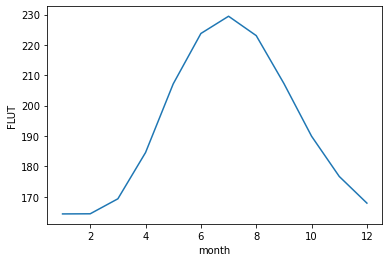

In [26]:
ensavg_olr_ds['FLUT'].sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(label='ens avg')

Not using the cesm time fix works here right now. Not sure why not needed....

### Iterate over CESM1 ensemble members and variables of interest

In [16]:
cesmle_path = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'

In [17]:
# hardcoded alternate with only ensembles we can use
ensemble_nums = [
    '001', '002', '003', '004', '005', 
    '006', '007', '008', '009', '010',
    '011', '012', '013', '014', '015',
    '016', '017', '018', '019', '020',
    '021', '022', '023', '024', '025', 
    '026', '027', '028', '029', '030', 
    '031', '032', '033', '034', '035', 
    '101', '102', '103', '104', '105'
]

#### Collect all paths in a dictionary

In [27]:
path_dict = {} # key is the ensemble number
_var = 'FLUT'

for _ensn in ensemble_nums:
    _t1_file = glob.glob('%s/%s/b.e11.B20TRC5CNBDRD.f09_g16.%s.cam.h0.%s.1??001-200512.nc' % (cesmle_path,_var,_ensn,_var))
    _t2_file = glob.glob('%s/%s/b.e11.BRCP85C5CNBDRD.f09_g16.%s.cam.h0.%s.200601-2???12.nc' % (cesmle_path,_var,_ensn,_var))

    if (len(_t1_file) != 1) or (len(_t2_file) != 1):
        print('glob returned ambiguous (or zero) file names for ensemble member %s' % _ensn)
        break
    # try:
    path_dict[_ensn] = [*_t1_file,*_t2_file]
    # except:
    #     path_dict[_ensn] = {_var: [*_t1_file,*_t2_file]}    

#### Demonstrate broken fix_cesm_time code. (not sure why)

In [28]:
ensavg_olr_paths = glob.glob('%s/*FLUT*.nc' % (ensavg_path)) # get appropriate files

_ensavg_olr_preproc = xr.open_mfdataset(ensavg_olr_paths)

In [29]:
_ens_olr_testfiles = path_dict['001']

_ens_olr_testds = xr.open_mfdataset(_ens_olr_testfiles)

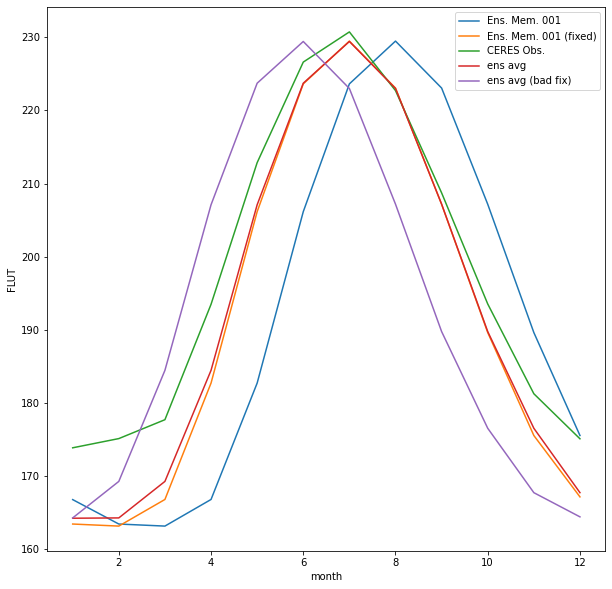

In [36]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

_ens_olr_testds['FLUT'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(ax=ax,label='Ens. Mem. 001')
fix_cesm_time(_ens_olr_testds)['FLUT'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(ax=ax,label='Ens. Mem. 001 (fixed)')

ceres_subset.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(ax=ax,label='CERES Obs.')

_ensavg_olr_preproc['FLUT'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(label='ens avg')

fix_cesm_time(_ensavg_olr_preproc)['FLUT'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(69,None)).groupby('time.month').mean(dim=['time','lat','lon']).plot(label='ens avg (bad fix)')

plt.legend()

#### Calculate an Arctic jfm OLR timeseries for each member in the CESM1-LE

Nothing is changing. Are CESM1-LE files corrected now? Why don't they agree with the data I processed previously then? What is a good simple test? Looking at the month where OLR is at a minimum?

In [40]:
ens_olr_tseries_dict = {}

for _ens_num in ensemble_nums: # iterate over ensemble members
    
    _ens_olr_files = path_dict[_ens_num]
    
    _ens_olr_ds = xr.open_mfdataset(_ens_olr_files).chunk({'lat':-1,'lon':-1}) # chunk to prep for lat-lon interpolation

    _ens_interp = _ens_olr_ds['FLUT'].interp_like(ceres_subset.isel(time=0)) # interpolated before subsetting, could use xESMF

    _ens_subset = _ens_interp.sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None))

    _ens_subset_wgtd = add_weights(_ens_subset) # add area-weighting coordinate
    _ens_subset_spatavg = masked_average(_ens_subset_wgtd,dim=['lat','lon'],weights=_ens_subset_wgtd['cell_weight']) # I will need to interpolate for complete consistency with observations jshaw,TODO
    _ens_subset_jfm = _ens_subset_spatavg.sel(time=is_jfm(_ens_subset_spatavg.time)) # select jan, feb, mar
    _ens_subset_jfmavg = _ens_subset_jfm.groupby('time.year').mean('time') # average into an annual timeseries
    
    _ens_subset_jfmavg['ens'] = int(_ens_num) # add ensemble coordinate for easy combining
    
    ens_olr_tseries_dict[_ens_num] = _ens_subset_jfmavg #.chunk({'year':-1,'ens':-1}) # store in proc_dict
        
    # if _ens_num == '013':break
    
# combine along the new dimension and DECHUNK. This makes sense but slows things down ALOT
allens_tseries = xr.concat(list(ens_olr_tseries_dict.values()),dim='ens').chunk({'year':-1,'ens':-1})

In [25]:
# ens_olr_tseries_dict = {}

# for _ens_num in ensemble_nums: # iterate over ensemble members
    
#     _ens_olr_files = path_dict[_ens_num]['FLUT']
    
# #     _data_ds = xr.open_mfdataset(_ens_olr_files)
    
# #     break
#     _ens_subset = arc_subset(*_ens_olr_files,var='FLUT',chunks={'time':-1,'lat':-1,'lon':-1}) # to dechunk
    
#     _subset_wgtd = add_weights(_ens_subset) # add area-weighting coordinate
#     _subset_spatavg = masked_average(_subset_wgtd,dim=['lat','lon'],weights=_subset_wgtd['cell_weight']) # I will need to interpolate for complete consistency with observations jshaw,TODO
#     _subset_jfm = _subset_spatavg.sel(time=is_jfm(_subset_spatavg.time)) # select jan, feb, mar
#     _subset_jfmavg = _subset_jfm.groupby('time.year').mean('time').chunk({'year':-1}) # average into an annual timeseries, dechunk for whatever reason
    
#     _subset_jfmavg['ens'] = int(_ens_num) # add ensemble coordinate for easy combining
    
#     ens_olr_tseries_dict[_ens_num] = _subset_jfmavg #.chunk({'year':-1,'ens':-1}) # store in proc_dict
        
#     # if _ens_num == '013':break
    
# # combine along the new dimension and DECHUNK. This makes sense but slows things down ALOT
# allens_tseries = xr.concat(list(ens_olr_tseries_dict.values()),dim='ens').chunk({'year':-1,'ens':-1})

#### This final plotting step is slow, maybe because all the operations are delayed? I have tried chunking differently.

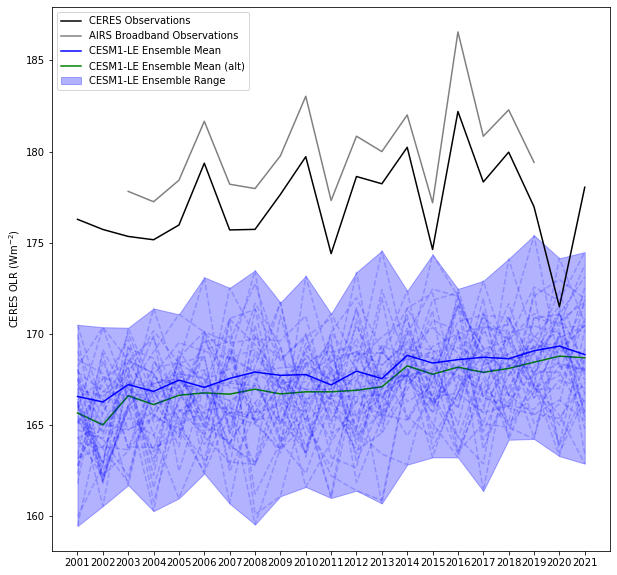

In [41]:
fig3,ax3 = plt.subplots(1,1,figsize=(10,10))

# Plot CERES data:
ax3.plot(ceres_subset_jfmavg['year'],ceres_subset_jfmavg,label='CERES Observations',color='black')

# Plot AIRS data:
ax3.plot(airs_subset_jfmavg['year'],airs_subset_jfmavg,label='AIRS Broadband Observations',color='grey')
# ceres_subset_jfmavg

# Plot CESM1-LE ensemble average data
ax3.plot(ensavg_subset_jfmavg['year'],ensavg_subset_jfmavg,label='CESM1-LE Ensemble Mean',color='blue')

# calculate ensemble maximum and minimum values at each timestep, this shouldn't be so slow but maybe all the operations are dask.delayed...
lens_max = allens_tseries.max(dim='ens').values # speeds up somewhat. My code must be bad somewhere...
lens_min = allens_tseries.min(dim='ens').values
lens_avg = allens_tseries.mean(dim='ens').values

ax3.plot(allens_tseries['year'],lens_avg,label='CESM1-LE Ensemble Mean (alt)',color='green')


ax3.fill_between(x=allens_tseries['year'],y1=lens_min,y2=lens_max,label='CESM1-LE Ensemble Range',color='blue',alpha=0.3)

# for _ens_tseries in allens_tseries: # iterate over ensembles
#     ax3.plot(_ens_tseries['year'],_ens_tseries,alpha=0.3,linestyle='dashed',color='blue') 
    

for _ens_num in ens_olr_tseries_dict: # alternate faster iterate over ensembles
    ax3.plot(ens_olr_tseries_dict[_ens_num]['year'],ens_olr_tseries_dict[_ens_num],alpha=0.2,linestyle='dashed',color='blue') 

ax3.set_ylabel('CERES OLR (Wm$^{-2}$)')
ax3.set_xticks(ceres_subset_jfmavg['year']) # this is weird and returns something if it's the last line in a cell

plt.legend()

## Plot with variable ranges for most extreme ensemble members

Text(0.5, 0.95, 'Trends in CESM1-LE Ensemble Average')

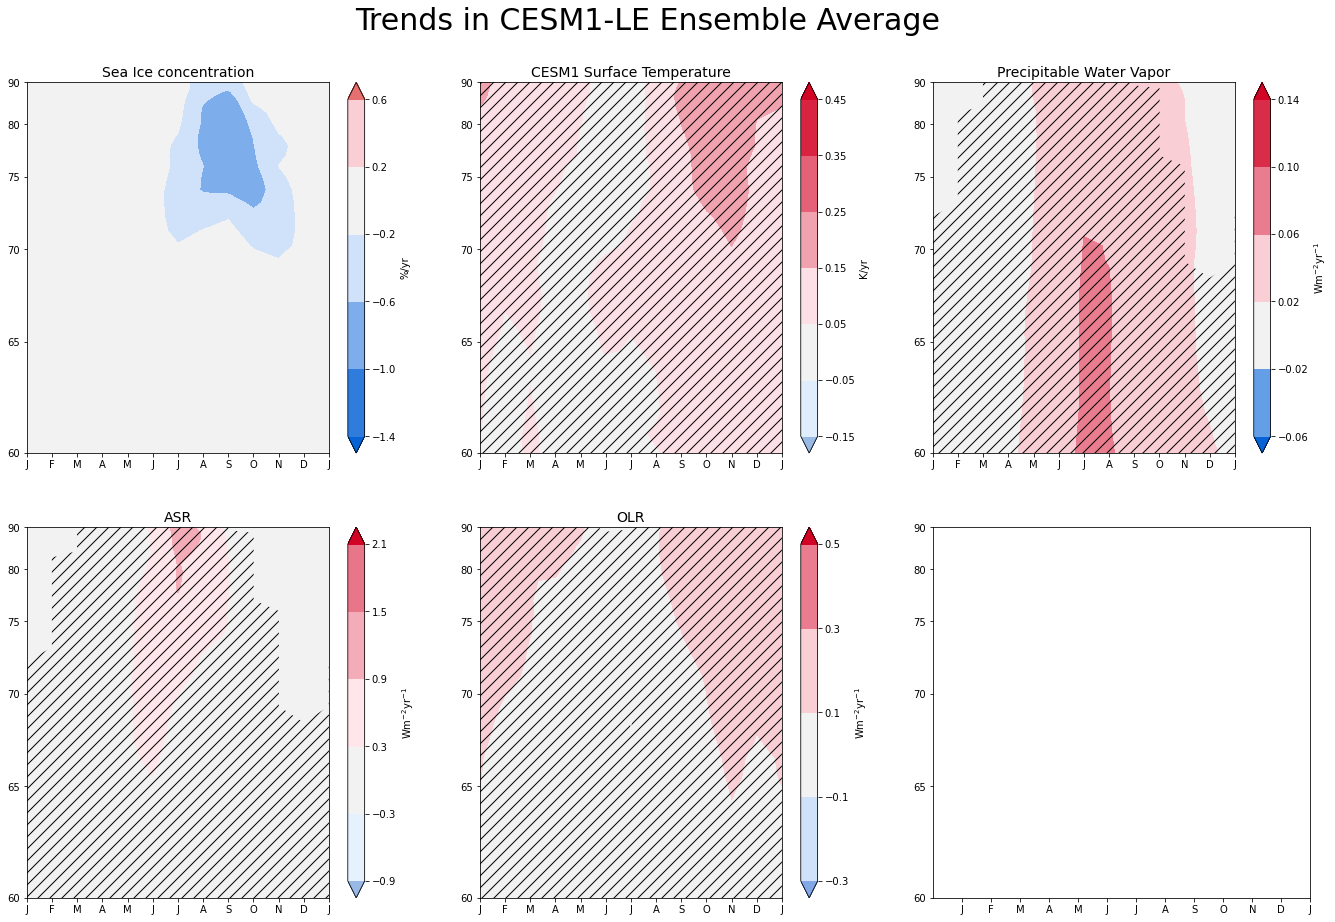

In [15]:
_olr = proc_dict['FLUT']
_asr = proc_dict['FSNTOA']
_icefrac = 100*proc_dict['ICEFRAC']
_ts = proc_dict['TS']
_tmq = proc_dict['TMQ']

ts_trends_wrapped = xr.concat([_ts['TREND'],_ts['TREND'][0].assign_coords({'month':13})],dim='month')
ts_statsig_wrapped = xr.concat([_ts['STATSIG'],_ts['STATSIG'][0].assign_coords({'month':13})],dim='month')

seaice_trends_wrapped = xr.concat([_icefrac['TREND'],_icefrac['TREND'][0].assign_coords({'month':13})],dim='month')
seaice_statsig_wrapped = xr.concat([_icefrac['STATSIG'],_icefrac['STATSIG'][0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([_asr['TREND'],_asr['TREND'][0].assign_coords({'month':13})],dim='month')
asr_statsig_wrapped = xr.concat([_asr['STATSIG'],_asr['STATSIG'][0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([_olr['TREND'],_olr['TREND'][0].assign_coords({'month':13})],dim='month')
olr_statsig_wrapped = xr.concat([_olr['STATSIG'],_olr['STATSIG'][0].assign_coords({'month':13})],dim='month')

tmq_trends_wrapped = xr.concat([_tmq['TREND'],_tmq['TREND'][0].assign_coords({'month':13})],dim='month')
tmq_statsig_wrapped = xr.concat([_tmq['STATSIG'],_tmq['STATSIG'][0].assign_coords({'month':13})],dim='month')
tmq_pct_trends_wrapped = xr.concat([tmq_pct_trends,tmq_pct_trends[0].assign_coords({'month':13})],dim='month')

fig1,axs = plt.subplots(nrows=2,ncols=3,figsize=(23,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
cmap0 = copy.copy(palette)
im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'),
                       cmap=cmap0,extend='both',levels=np.arange(-1.4,0.61,0.4),vmin=-1.4,vmax=1.4)
im0.cmap.set_over((0.9,0.44,0.44))
stip = axes[0].contourf(seaice_statsig_wrapped['month'],lat_weighted0,seaice_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')

lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'),
                       cmap=cmap1,extend='both',levels=np.arange(-0.15,0.451,0.1),vmin=-0.45,vmax=0.45)
im1.cmap.set_under((0.6,0.72,0.89))
stip = axes[1].contourf(ts_statsig_wrapped['month'],lat_weighted1,ts_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('CESM1 Surface Temperature',fontsize=14)
cbar = plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*tmq_trends_wrapped['lat'])
im2 = axes[2].contourf(tmq_trends_wrapped['month'],lat_weighted2,tmq_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.06, vcenter=0., vmax=0.14),extend='both',levels=np.arange(-0.06,0.141,0.04))
stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('Precipitable Water Vapor',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

# lat_weighted5 = np.sin(np.pi/180*tmq_trends_wrapped['lat'])
# im5 = axes[5].contourf(tmq_trends_wrapped['month'],lat_weighted2,tmq_trends_wrapped.transpose('lat','month'), # -0.6,3.0
#                        cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.06, vcenter=0., vmax=0.14),extend='both',levels=np.arange(-0.06,0.141,0.04))
# stip = axes[5].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
# axes[5].set_title('Precipitable Water Vapor',fontsize=14)
# plt.colorbar(im5,ax=axes[5],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
cmap3 = copy.copy(palette)
im3 = axes[3].contourf(asr_trends_wrapped['month'],lat_weighted3,asr_trends_wrapped.transpose('lat','month'),
                       cmap=cmap3,extend='both',levels=np.arange(-0.9,2.11,0.6),vmin=-3.0,vmax=3.0)
im3.cmap.set_under((0.6,0.72,0.89))
stip = axes[3].contourf(asr_statsig_wrapped['month'],lat_weighted3,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('ASR',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted4 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
cmap4 = copy.copy(palette)
im4 = axes[4].contourf(olr_trends_wrapped['month'],lat_weighted4,olr_trends_wrapped.transpose('lat','month'),
                       cmap=cmap4,extend='both',levels=np.arange(-0.3,0.7,0.2),vmin=-0.7,vmax=0.7)
im4.cmap.set_under((0.51,0.66,0.9))
stip = axes[4].contourf(olr_statsig_wrapped['month'],lat_weighted4,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')
axes[4].set_title('OLR',fontsize=14)
plt.colorbar(im4,ax=axes[4],label='Wm$^{-2}$yr$^{-1}$')

fig1.suptitle('Trends in CESM1-LE Ensemble Average',fontsize=30,y=0.95)

## Plot with variable ranges for observations (more detailed)

In [10]:
_olr = proc_dict['FLUT']
_asr = proc_dict['FSNTOA']
_icefrac = 100*proc_dict['ICEFRAC']
_ts = proc_dict['TS']
_tmq = proc_dict['TMQ']

ts_trends_wrapped = xr.concat([_ts['TREND'],_ts['TREND'][0].assign_coords({'month':13})],dim='month')
ts_statsig_wrapped = xr.concat([_ts['STATSIG'],_ts['STATSIG'][0].assign_coords({'month':13})],dim='month')

seaice_trends_wrapped = xr.concat([_icefrac['TREND'],_icefrac['TREND'][0].assign_coords({'month':13})],dim='month')
seaice_statsig_wrapped = xr.concat([_icefrac['STATSIG'],_icefrac['STATSIG'][0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([_asr['TREND'],_asr['TREND'][0].assign_coords({'month':13})],dim='month')
asr_statsig_wrapped = xr.concat([_asr['STATSIG'],_asr['STATSIG'][0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([_olr['TREND'],_olr['TREND'][0].assign_coords({'month':13})],dim='month')
olr_statsig_wrapped = xr.concat([_olr['STATSIG'],_olr['STATSIG'][0].assign_coords({'month':13})],dim='month')

tmq_trends_wrapped = xr.concat([_tmq['TREND'],_tmq['TREND'][0].assign_coords({'month':13})],dim='month')
tmq_statsig_wrapped = xr.concat([_tmq['STATSIG'],_tmq['STATSIG'][0].assign_coords({'month':13})],dim='month')
tmq_pct_trends_wrapped = xr.concat([tmq_pct_trends,tmq_pct_trends[0].assign_coords({'month':13})],dim='month')

fig1,axs = plt.subplots(nrows=2,ncols=3,figsize=(23,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
cmap0 = copy.copy(palette)
im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap=cmap0,levels=np.arange(-1.35,0.156,0.3),vmin=-1.35,vmax=1.35,extend='both')
im0.cmap.set_over('lightpink') # (0.51,0.66,0.9)
# stip = axes[0].contourf(seaice_statsig_wrapped['month'],lat_weighted0,seaice_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')

lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap=cmap1,vmin=-0.25, vmax=0.25,levels=np.arange(-0.075,0.2251,0.05),extend='both')
im1.cmap.set_under((0.51,0.66,0.9))
# stip = axes[1].contourf(ts_statsig_wrapped['month'],lat_weighted1,ts_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[1].set_title('CESM1 Surface Temperature',fontsize=14)
cbar = plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*tmq_trends_wrapped['lat'])
cmap2 = copy.copy(palette)
im2 = axes[2].contourf(tmq_trends_wrapped['month'],lat_weighted2,tmq_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap=cmap2,vmin=-0.07, vmax=0.07,extend='both',levels=np.arange(-0.05,0.071,0.02))
im2.cmap.set_under((0.81,0.91,1.00))
# stip = axes[2].contourf(tmq_statsig_wrapped['month'],lat_weighted2,tmq_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[2].set_title('Precipitable Water Vapor (absolute)',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='mmyr$^{-1}$')

lat_weighted5 = np.sin(np.pi/180*tmq_pct_trends_wrapped['lat'])
cmap5 = copy.copy(palette)
im5 = axes[5].contourf(tmq_pct_trends_wrapped['month'],lat_weighted2,100*tmq_pct_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap=cmap5,extend='both',vmin=-0.75, vmax=0.75,levels=np.arange(-0.75,0.751,0.3))
# im5.cmap.set_under((0.81,0.91,1.00))
# stip = axes[5].contourf(tmq_statsig_wrapped['month'],lat_weighted5,tmq_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[5].set_title('Precipitable Water Vapor (normalized)',fontsize=14)
plt.colorbar(im5,ax=axes[5],label='%yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
cmap3 = copy.copy(palette)
im3 = axes[3].contourf(asr_trends_wrapped['month'],lat_weighted3,asr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=cmap3,vmin=-1.05, vmax=1.05,levels=np.arange(-0.15,1.06,0.30),extend='both')
im3.cmap.set_under((0.81,0.91,1.00))
# stip = axes[3].contourf(asr_statsig_wrapped['month'],lat_weighted3,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[3].set_title('ASR',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted4 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
cmap4 = copy.copy(palette)
im4 = axes[4].contourf(olr_trends_wrapped['month'],lat_weighted4,olr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=cmap4,vmin=-0.36,vmax=0.36,levels=np.arange(-0.04,0.36,0.08),extend='both')
im4.cmap.set_under((0.81,0.91,1.00))
# stip = axes[4].contourf(olr_statsig_wrapped['month'],lat_weighted4,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[4].set_title('OLR',fontsize=14)
plt.colorbar(im4,ax=axes[4],label='Wm$^{-2}$yr$^{-1}$')

fig1.suptitle('Trends in CESM1-LE Ensemble Average',fontsize=30,y=0.95)

NameError: name 'tmq_pct_trends' is not defined

#### 4-panel version

Text(0.5, 0.95, 'CESM1-LE Forced Response')

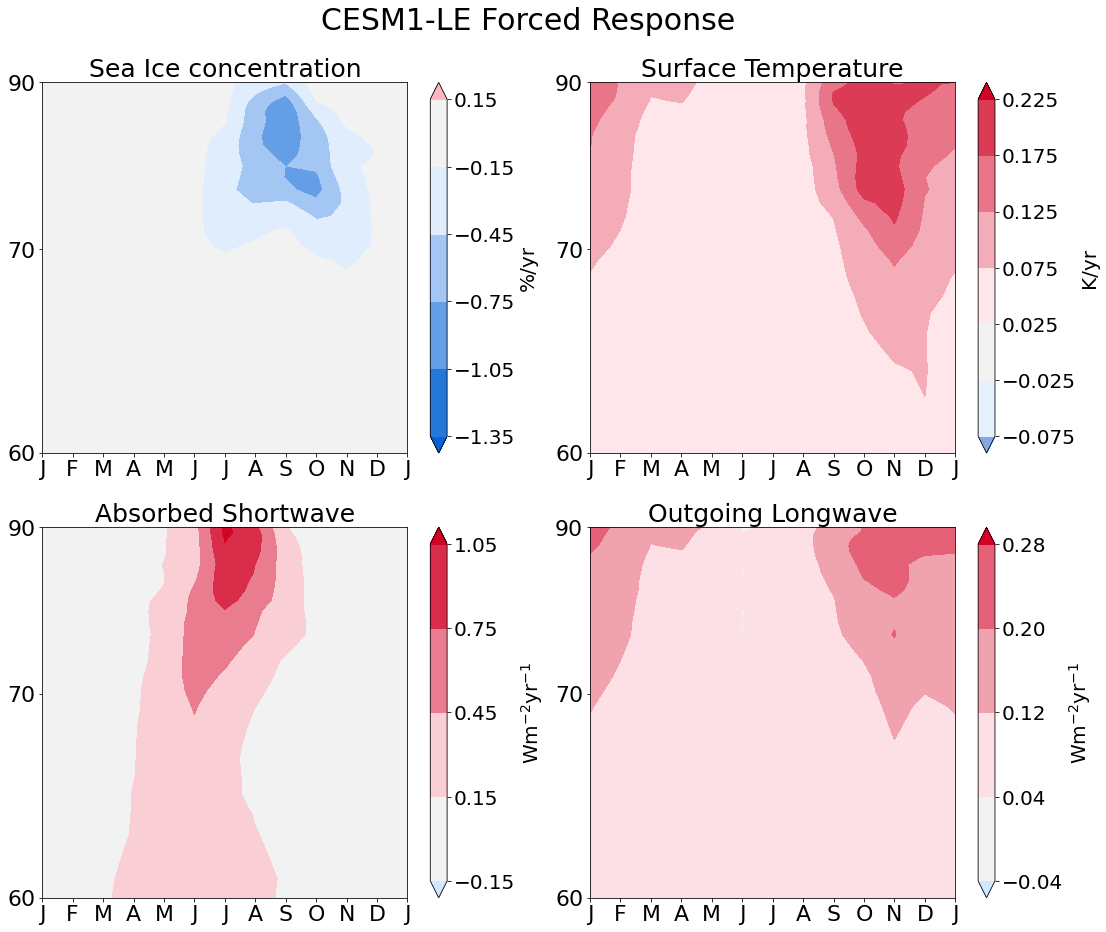

In [16]:
_olr = proc_dict['FLUT']
_asr = proc_dict['FSNTOA']
_icefrac = 100*proc_dict['ICEFRAC']
_ts = proc_dict['TS']
_tmq = proc_dict['TMQ']

ts_trends_wrapped = xr.concat([_ts['TREND'],_ts['TREND'][0].assign_coords({'month':13})],dim='month')
ts_statsig_wrapped = xr.concat([_ts['STATSIG'],_ts['STATSIG'][0].assign_coords({'month':13})],dim='month')

seaice_trends_wrapped = xr.concat([_icefrac['TREND'],_icefrac['TREND'][0].assign_coords({'month':13})],dim='month')
seaice_statsig_wrapped = xr.concat([_icefrac['STATSIG'],_icefrac['STATSIG'][0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([_asr['TREND'],_asr['TREND'][0].assign_coords({'month':13})],dim='month')
asr_statsig_wrapped = xr.concat([_asr['STATSIG'],_asr['STATSIG'][0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([_olr['TREND'],_olr['TREND'][0].assign_coords({'month':13})],dim='month')
olr_statsig_wrapped = xr.concat([_olr['STATSIG'],_olr['STATSIG'][0].assign_coords({'month':13})],dim='month')

tmq_trends_wrapped = xr.concat([_tmq['TREND'],_tmq['TREND'][0].assign_coords({'month':13})],dim='month')
tmq_statsig_wrapped = xr.concat([_tmq['STATSIG'],_tmq['STATSIG'][0].assign_coords({'month':13})],dim='month')

fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(18,15))
fig1.subplots_adjust(wspace=0.2,hspace=0.2)

axes = axs.flat

# ytick_labels = np.array([60,65,70,75,80,90])
ytick_labels = np.array([60,70,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels,fontsize=22)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels,fontsize=22)

lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
cmap0 = copy.copy(palette)
im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap=cmap0,levels=np.arange(-1.35,0.156,0.3),vmin=-1.35,vmax=1.35,extend='both')
im0.cmap.set_over('lightpink') # (0.51,0.66,0.9)
# stip = axes[0].contourf(seaice_statsig_wrapped['month'],lat_weighted0,seaice_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration',fontsize=25)
cbar0 = plt.colorbar(im0,ax=axes[0])
cbar0.ax.tick_params(labelsize=20)
cbar0.set_label(label='%/yr',fontsize=20)

lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap=cmap1,vmin=-0.25, vmax=0.25,levels=np.arange(-0.075,0.2251,0.05),extend='both')
im1.cmap.set_under((0.51,0.66,0.9))
# stip = axes[1].contourf(ts_statsig_wrapped['month'],lat_weighted1,ts_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[1].set_title('Surface Temperature',fontsize=25)
cbar1 = plt.colorbar(im1,ax=axes[1])
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(label='K/yr',fontsize=20)
# axes[1].set_title('Surface Temperature',fontsize=14)
# cbar = plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
cmap2 = copy.copy(palette)
im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=cmap2,vmin=-1.05, vmax=1.05,levels=np.arange(-0.15,1.06,0.30),extend='both')
im2.cmap.set_under((0.81,0.91,1.00))
# stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[2].set_title('Absorbed Shortwave',fontsize=25)
cbar2 = plt.colorbar(im2,ax=axes[2])
cbar2.ax.tick_params(labelsize=20)
cbar2.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)
# axes[2].set_title('ASR',fontsize=14)
# plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
cmap3 = copy.copy(palette)
im3 = axes[3].contourf(olr_trends_wrapped['month'],lat_weighted3,olr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=cmap3,vmin=-0.36,vmax=0.36,levels=np.arange(-0.04,0.36,0.08),extend='both')
im3.cmap.set_under((0.81,0.91,1.00))
# stip = axes[3].contourf(olr_statsig_wrapped['month'],lat_weighted3,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[3].set_title('Outgoing Longwave',fontsize=25)
cbar3 = plt.colorbar(im3,ax=axes[3])
cbar3.ax.tick_params(labelsize=20)
cbar3.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)
# axes[3].set_title('OLR',fontsize=14)
# plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')

fig1.suptitle('CESM1-LE Forced Response',fontsize=30,y=0.95)

In [17]:
to_png(fig1,'forcedresponse_4panel')

Text(0.5, 0.95, 'CESM1-LE Forced Response')

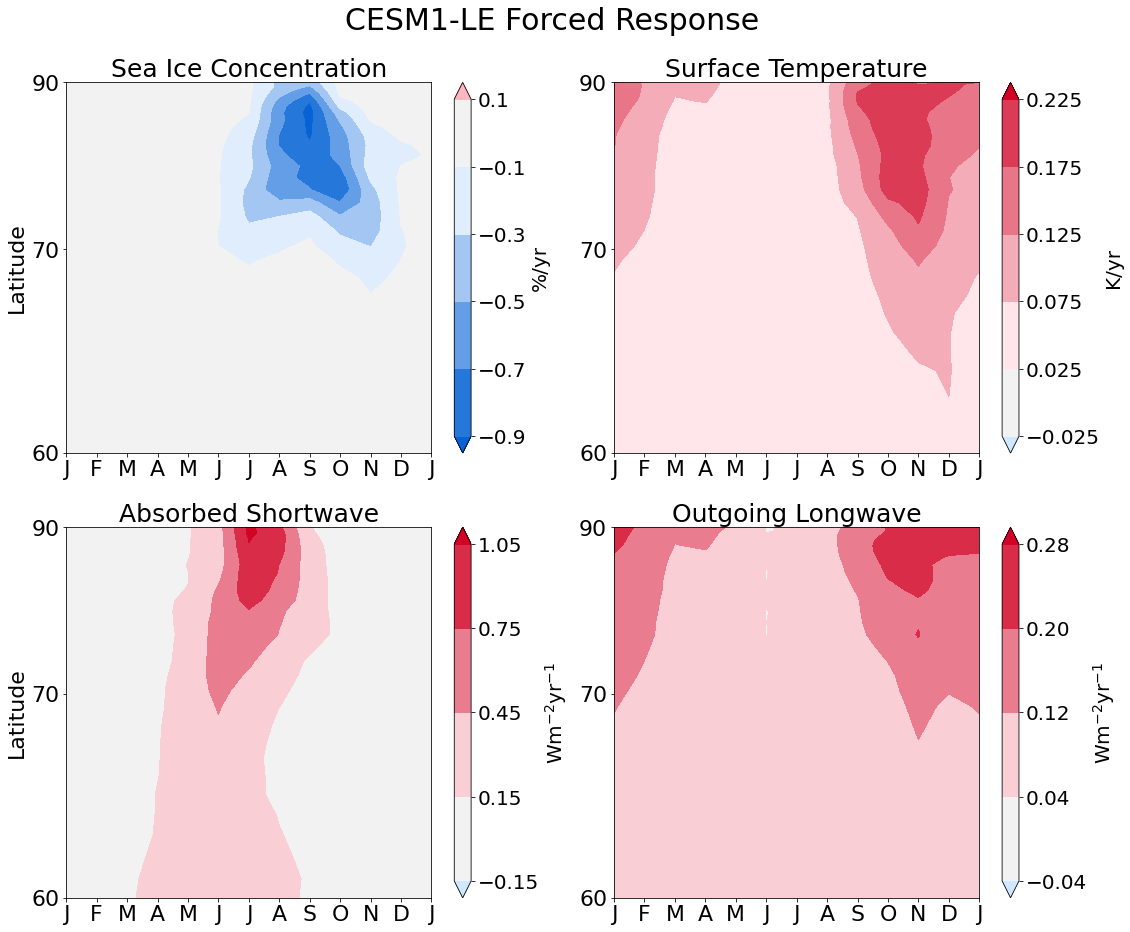

In [13]:
_olr = proc_dict['FLUT']
_asr = proc_dict['FSNTOA']
_icefrac = 100*proc_dict['ICEFRAC']
_ts = proc_dict['TS']
_tmq = proc_dict['TMQ']

ts_trends_wrapped = xr.concat([_ts['TREND'],_ts['TREND'][0].assign_coords({'month':13})],dim='month')
ts_statsig_wrapped = xr.concat([_ts['STATSIG'],_ts['STATSIG'][0].assign_coords({'month':13})],dim='month')

seaice_trends_wrapped = xr.concat([_icefrac['TREND'],_icefrac['TREND'][0].assign_coords({'month':13})],dim='month')
seaice_statsig_wrapped = xr.concat([_icefrac['STATSIG'],_icefrac['STATSIG'][0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([_asr['TREND'],_asr['TREND'][0].assign_coords({'month':13})],dim='month')
asr_statsig_wrapped = xr.concat([_asr['STATSIG'],_asr['STATSIG'][0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([_olr['TREND'],_olr['TREND'][0].assign_coords({'month':13})],dim='month')
olr_statsig_wrapped = xr.concat([_olr['STATSIG'],_olr['STATSIG'][0].assign_coords({'month':13})],dim='month')

# tmq_trends_wrapped = xr.concat([_tmq['TREND'],_tmq['TREND'][0].assign_coords({'month':13})],dim='month')
# tmq_statsig_wrapped = xr.concat([_tmq['STATSIG'],_tmq['STATSIG'][0].assign_coords({'month':13})],dim='month')

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(18,15))
fig1.subplots_adjust(wspace=0.2,hspace=0.2)

axes = axs.flat

# ytick_labels = np.array([60,65,70,75,80,90])
ytick_labels = np.array([60,70,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels,fontsize=22)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels,fontsize=22)

axes[0].set_ylabel('Latitude',fontsize=22)
axes[2].set_ylabel('Latitude',fontsize=22)
    
lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
cmap0 = copy.copy(palette)
im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'),
                       cmap=cmap0,extend='both',levels=np.arange(-0.9,0.11,0.2),vmin=-0.9,vmax=0.9)
im0.cmap.set_over('lightpink')
# stip = axes[0].contourf(seaice_statsig_wrapped['month'],lat_weighted0,seaice_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice Concentration',fontsize=25)
cbar0 = plt.colorbar(im0,ax=axes[0])
cbar0.ax.tick_params(labelsize=20)
cbar0.set_label(label='%/yr',fontsize=20)

lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
cmap1 = copy.copy(palette)
im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'),
                       cmap=cmap1,extend='both',levels=np.arange(-0.025,0.2251,0.05),vmin=-0.25,vmax=0.25)
im1.cmap.set_under((0.81,0.91,1.00))
# stip = axes[1].contourf(ts_statsig_wrapped['month'],lat_weighted1,ts_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[1].set_title('Surface Temperature',fontsize=25)
cbar1 = plt.colorbar(im1,ax=axes[1])
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(label='K/yr',fontsize=20)

lat_weighted2 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
cmap2 = copy.copy(palette)
im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'),
                       cmap=cmap2,extend='both',levels=np.arange(-0.15,1.06,0.30),vmin=-1.05,vmax=1.05)
im2.cmap.set_under((0.81,0.91,1.00))
# stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[2].set_title('Absorbed Shortwave',fontsize=25)
cbar2 = plt.colorbar(im2,ax=axes[2])
cbar2.ax.tick_params(labelsize=20)
cbar2.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

lat_weighted3 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
cmap3 = copy.copy(palette)
im3 = axes[3].contourf(olr_trends_wrapped['month'],lat_weighted3,olr_trends_wrapped.transpose('lat','month'),
                       cmap=cmap3,extend='both',levels=np.arange(-0.04,0.36,0.08),vmin=-0.28,vmax=0.28)
im3.cmap.set_under((0.81,0.91,1.00))
# stip = axes[3].contourf(olr_statsig_wrapped['month'],lat_weighted3,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[3].set_title('Outgoing Longwave',fontsize=25)
cbar3 = plt.colorbar(im3,ax=axes[3])
cbar3.ax.tick_params(labelsize=20)
cbar3.set_label(label='Wm$^{-2}$yr$^{-1}$',fontsize=20)

fig1.suptitle('CESM1-LE Forced Response',fontsize=30,y=0.95)

In [14]:
to_png(fig1,'forcedresponse_4panel')

## Stack ensemble trends

Will need to add an extra coordinates and then use an xr.merge or similar command

In [75]:
memberavg_path = '/glade/work/jonahshaw/LENS/CESM1-LE/ArcticMemberTrends/'

In [76]:
model_variables = ['ICEFRAC','FLUT','FSNTOA','TS','LANDFRAC']

In [77]:
# hardcoded alternate with only ensembles we can use
ensemble_nums = [
    '001', '002', '003', '004', '005', 
    '006', '007', '008', '009', '010',
    '011', '012', '013', '014', '015',
    '016', '017', '018', '019', '020',
    '021', '022', '023', '024', '025', 
    '026', '027', '028', '029', '030', 
    '031', '032', '033', '034', '035', 
    '101', '102', '103', '104', '105'
]

#### Need to add another dimension in order to stack them.

In [162]:
multiens_dict = {}

for _var in model_variables:
    
    all_ens = [] # list to combine later
    
    for _ensn in ensemble_nums:            
        _file = glob.glob('%s/*%s.%s*.nc' % (memberavg_path,_var,_ensn))[0]
        _ds = xr.open_dataset(_file)
        
        _ds2 = _ds.assign_coords({'ensn':int(_ensn)}).expand_dims('ensn')
        _ds.close()
        
        if _ensn == '001': # handle a weird combining error by interpolating Toronto runs to standard grid
            _interptarget = _ds
        
        # add
        if _ensn in ['101','102','103','104','105',]: 
            _ds2 = _ds2.interp_like(_interptarget)
        
        all_ens.append(_ds2)
        
    multiens_dict[_var] = xr.combine_by_coords(all_ens)
    
#     break

#### Plot aggregated trends for sanity

Text(0.5, 0.95, 'Trends in CESM1-LE Ensemble Average (from individual trends)')

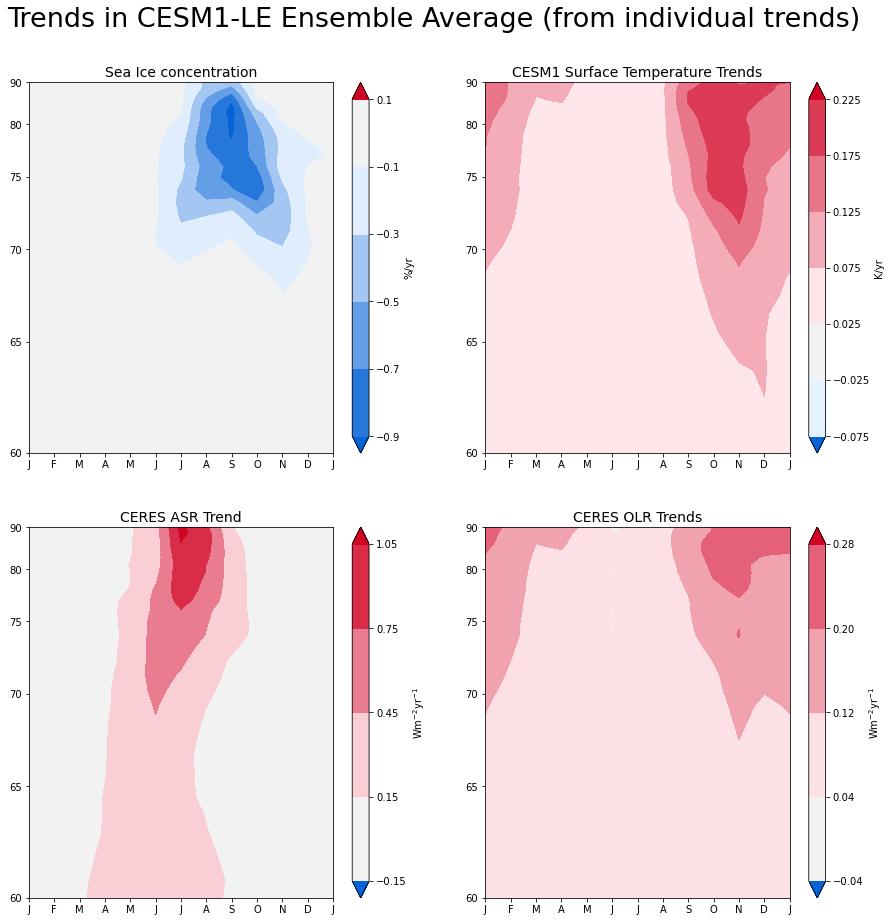

In [177]:
_olr2 = multiens_dict['FLUT'].mean(dim='ensn')
_asr2 = multiens_dict['FSNTOA'].mean(dim='ensn')
_icefrac2 = multiens_dict['ICEFRAC'].mean(dim='ensn')
_ts2 = multiens_dict['TS'].mean(dim='ensn')

ts_trends_wrapped = xr.concat([_ts2['TREND'],_ts2['TREND'][0].assign_coords({'month':13})],dim='month')
# ts_statsig_wrapped = xr.concat([_ts2['STATSIG'],_ts2['STATSIG'][0].assign_coords({'month':13})],dim='month')

seaice_trends_wrapped = xr.concat([_icefrac2['TREND'],_icefrac2['TREND'][0].assign_coords({'month':13})],dim='month')
# seaice_statsig_wrapped = xr.concat([_icefrac2['STATSIG'],_icefrac2['STATSIG'][0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([_asr2['TREND'],_asr2['TREND'][0].assign_coords({'month':13})],dim='month')
# asr_statsig_wrapped = xr.concat([_asr2['STATSIG'],_asr2['STATSIG'][0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([_olr2['TREND'],_olr2['TREND'][0].assign_coords({'month':13})],dim='month')
# olr_statsig_wrapped = xr.concat([_olr2['STATSIG'],_olr2['STATSIG'][0].assign_coords({'month':13})],dim='month')

fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(15,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')
# stip = axes[0].contourf(seaice_statsig_wrapped['month'],lat_weighted0,seaice_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')

lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0., vmax=0.25),levels=np.arange(-0.075,0.2251,0.05),extend='both')
# stip = axes[1].contourf(ts_statsig_wrapped['month'],lat_weighted1,ts_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[1].set_title('CESM1 Surface Temperature Trends',fontsize=14)
cbar = plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-1.05, vcenter=0., vmax=1.05),levels=np.arange(-0.15,1.06,0.30),extend='both')
# stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[2].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
im3 = axes[3].contourf(olr_trends_wrapped['month'],lat_weighted3,olr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.36, vcenter=0., vmax=0.36),levels=np.arange(-0.04,0.36,0.08),extend='both')
# stip = axes[3].contourf(olr_statsig_wrapped['month'],lat_weighted3,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[3].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')

fig1.suptitle('Trends in CESM1-LE Ensemble Average (from individual trends)',fontsize=27,y=0.95)

Text(0.5, 0.95, 'Trends in CESM1-LE Ensemble Average (from individual trends)')

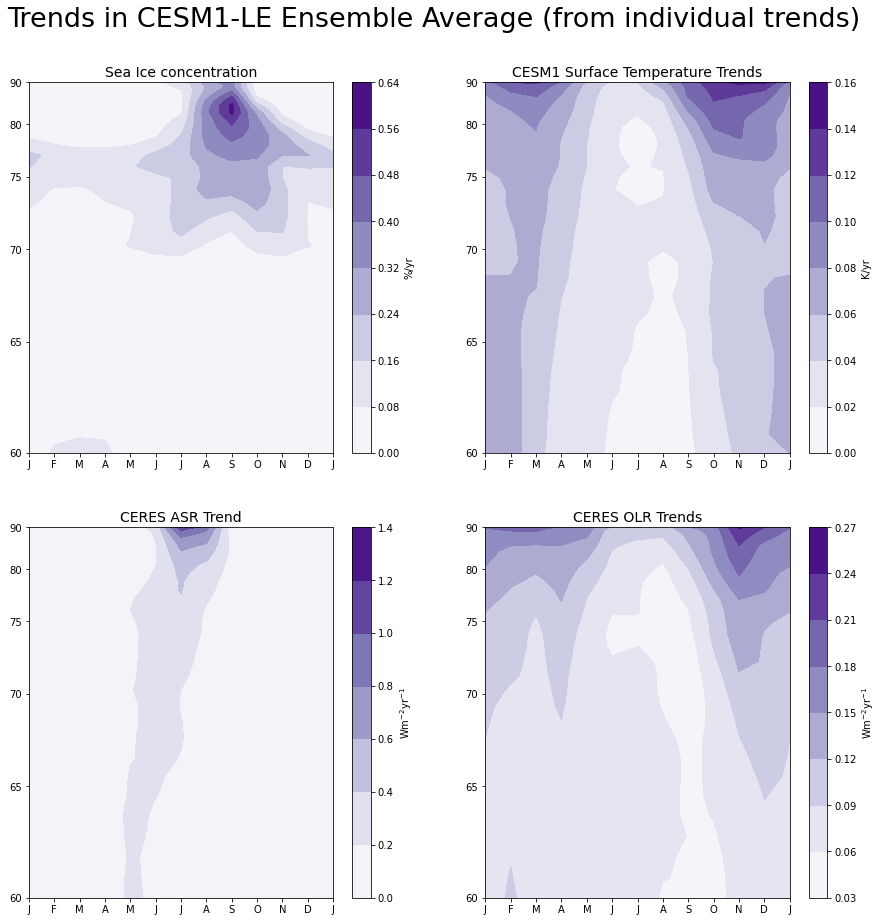

In [186]:
_olr2 = multiens_dict['FLUT'].std(dim='ensn')
_asr2 = multiens_dict['FSNTOA'].std(dim='ensn')
_icefrac2 = multiens_dict['ICEFRAC'].std(dim='ensn')
_ts2 = multiens_dict['TS'].std(dim='ensn')

ts_trends_wrapped = xr.concat([_ts2['TREND'],_ts2['TREND'][0].assign_coords({'month':13})],dim='month')
# ts_statsig_wrapped = xr.concat([_ts2['STATSIG'],_ts2['STATSIG'][0].assign_coords({'month':13})],dim='month')

seaice_trends_wrapped = xr.concat([_icefrac2['TREND'],_icefrac2['TREND'][0].assign_coords({'month':13})],dim='month')
# seaice_statsig_wrapped = xr.concat([_icefrac2['STATSIG'],_icefrac2['STATSIG'][0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([_asr2['TREND'],_asr2['TREND'][0].assign_coords({'month':13})],dim='month')
# asr_statsig_wrapped = xr.concat([_asr2['STATSIG'],_asr2['STATSIG'][0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([_olr2['TREND'],_olr2['TREND'][0].assign_coords({'month':13})],dim='month')
# olr_statsig_wrapped = xr.concat([_olr2['STATSIG'],_olr2['STATSIG'][0].assign_coords({'month':13})],dim='month')

fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(15,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap='Purples')#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')
# stip = axes[0].contourf(seaice_statsig_wrapped['month'],lat_weighted0,seaice_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')

lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap='Purples')#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0., vmax=0.25),levels=np.arange(-0.075,0.2251,0.05),extend='both')
# stip = axes[1].contourf(ts_statsig_wrapped['month'],lat_weighted1,ts_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[1].set_title('CESM1 Surface Temperature Trends',fontsize=14)
cbar = plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted2 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap='Purples')#,norm=mpl.colors.TwoSlopeNorm(vmin=-1.05, vcenter=0., vmax=1.05),levels=np.arange(-0.15,1.06,0.30),extend='both')
# stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[2].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
im3 = axes[3].contourf(olr_trends_wrapped['month'],lat_weighted3,olr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap='Purples')#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.36, vcenter=0., vmax=0.36),levels=np.arange(-0.04,0.36,0.08),extend='both')
# stip = axes[3].contourf(olr_statsig_wrapped['month'],lat_weighted3,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,99,100],
#                         hatches=[None,'//'],extend='neither')
axes[3].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')

fig1.suptitle('Trends in CESM1-LE Ensemble Average (from individual trends)',fontsize=27,y=0.95)

### Combine both for a more complete visualization

Text(0.5, 0.95, 'Trends in CESM1-LE Ensemble Average (from individual trends)')

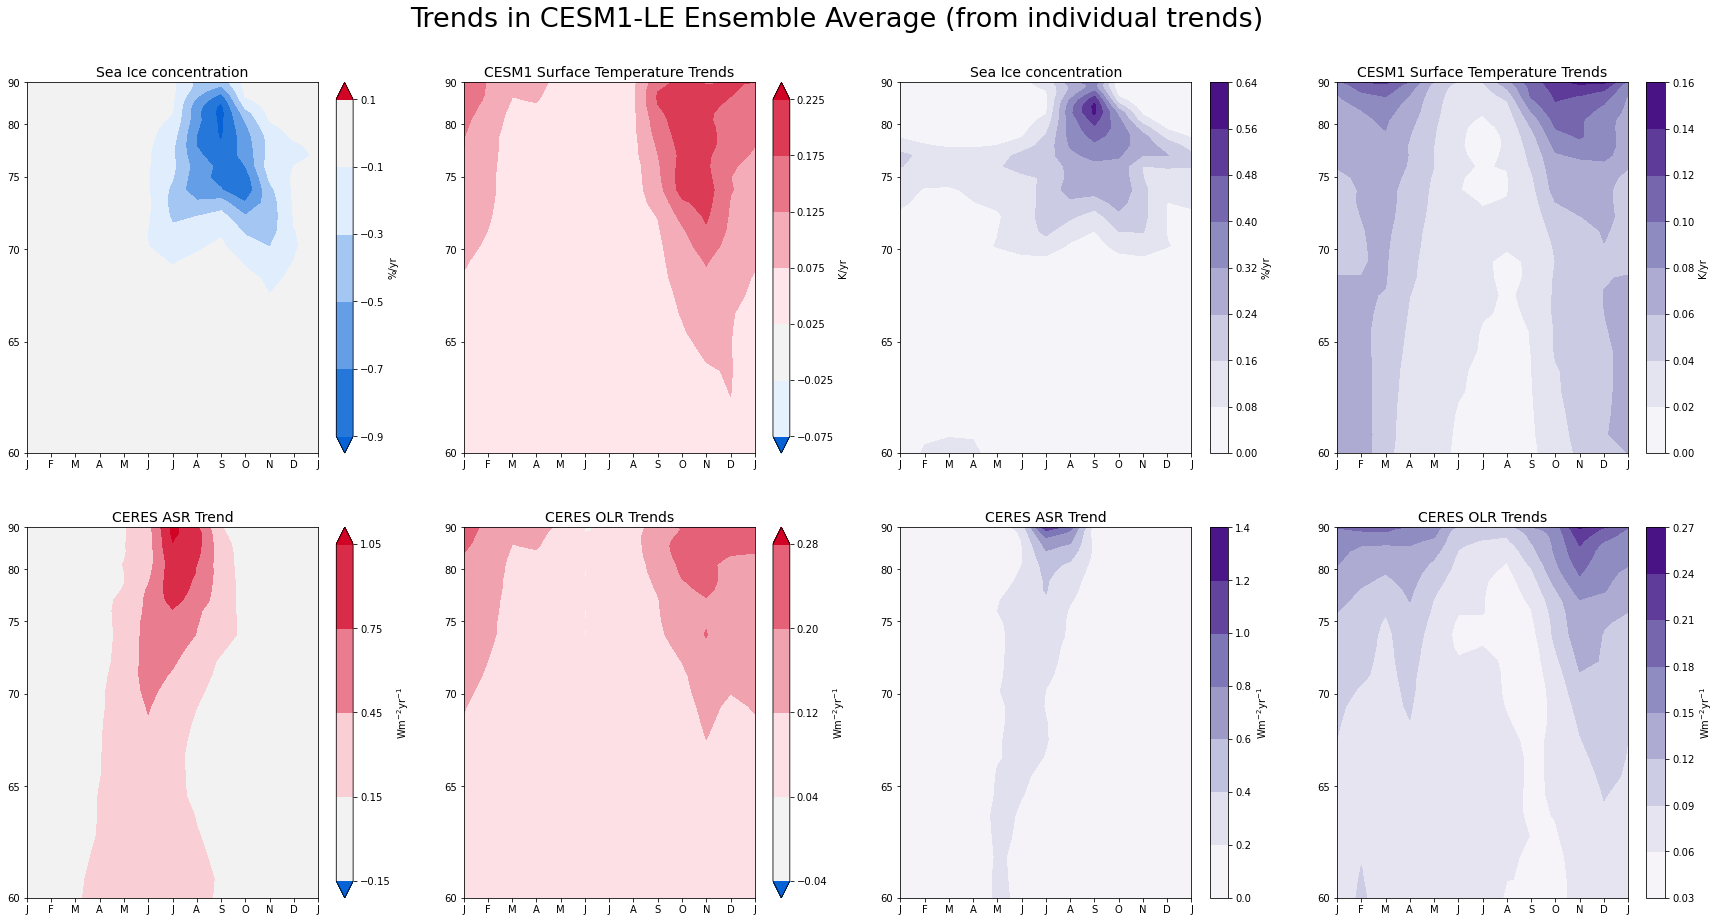

In [201]:
_olr2 = multiens_dict['FLUT'].mean(dim='ensn')
_asr2 = multiens_dict['FSNTOA'].mean(dim='ensn')
_icefrac2 = multiens_dict['ICEFRAC'].mean(dim='ensn')
_ts2 = multiens_dict['TS'].mean(dim='ensn')

_olr2std = multiens_dict['FLUT'].std(dim='ensn')
_asr2std = multiens_dict['FSNTOA'].std(dim='ensn')
_icefrac2std = multiens_dict['ICEFRAC'].std(dim='ensn')
_ts2std = multiens_dict['TS'].std(dim='ensn')

ts_trends_wrapped = xr.concat([_ts2['TREND'],_ts2['TREND'][0].assign_coords({'month':13})],dim='month')

seaice_trends_wrapped = xr.concat([_icefrac2['TREND'],_icefrac2['TREND'][0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([_asr2['TREND'],_asr2['TREND'][0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([_olr2['TREND'],_olr2['TREND'][0].assign_coords({'month':13})],dim='month')


ts_std_wrapped = xr.concat([_ts2std['TREND'],_ts2std['TREND'][0].assign_coords({'month':13})],dim='month')

seaice_std_wrapped = xr.concat([_icefrac2std['TREND'],_icefrac2std['TREND'][0].assign_coords({'month':13})],dim='month')

asr_std_wrapped = xr.concat([_asr2std['TREND'],_asr2std['TREND'][0].assign_coords({'month':13})],dim='month')

olr_std_wrapped = xr.concat([_olr2std['TREND'],_olr2std['TREND'][0].assign_coords({'month':13})],dim='month')

fig1,axs = plt.subplots(nrows=2,ncols=4,figsize=(30,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)

lat_weighted0 = np.sin(np.pi/180*seaice_trends_wrapped['lat'])
im0 = axes[0].contourf(seaice_trends_wrapped['month'],lat_weighted0,seaice_trends_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')
axes[0].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='%/yr')

lat_weighted1 = np.sin(np.pi/180*ts_trends_wrapped['lat'])
im1 = axes[1].contourf(ts_trends_wrapped['month'],lat_weighted1,ts_trends_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0., vmax=0.25),levels=np.arange(-0.075,0.2251,0.05),extend='both')
axes[1].set_title('CESM1 Surface Temperature Trends',fontsize=14)
cbar = plt.colorbar(im1,ax=axes[1],label='K/yr')

lat_weighted4 = np.sin(np.pi/180*asr_trends_wrapped['lat'])
im2 = axes[4].contourf(asr_trends_wrapped['month'],lat_weighted4,asr_trends_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-1.05, vcenter=0., vmax=1.05),levels=np.arange(-0.15,1.06,0.30),extend='both')
axes[4].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[4],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted5 = np.sin(np.pi/180*olr_trends_wrapped['lat'])
im3 = axes[5].contourf(olr_trends_wrapped['month'],lat_weighted5,olr_trends_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap=palette,norm=mpl.colors.TwoSlopeNorm(vmin=-0.36, vcenter=0., vmax=0.36),levels=np.arange(-0.04,0.36,0.08),extend='both')
axes[5].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[5],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted2 = np.sin(np.pi/180*seaice_std_wrapped['lat'])
im2 = axes[2].contourf(seaice_std_wrapped['month'],lat_weighted2,seaice_std_wrapped.transpose('lat','month'), # -1.4,0.4
                       cmap='Purples')#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')
axes[2].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='%/yr')

lat_weighted3 = np.sin(np.pi/180*ts_std_wrapped['lat'])
im3 = axes[3].contourf(ts_std_wrapped['month'],lat_weighted3,ts_std_wrapped.transpose('lat','month'), # -0.15,0.45
                       cmap='Purples')#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.25, vcenter=0., vmax=0.25),levels=np.arange(-0.075,0.2251,0.05),extend='both')
axes[3].set_title('CESM1 Surface Temperature Trends',fontsize=14)
cbar = plt.colorbar(im3,ax=axes[3],label='K/yr')

lat_weighted6 = np.sin(np.pi/180*asr_std_wrapped['lat'])
im6 = axes[6].contourf(asr_std_wrapped['month'],lat_weighted6,asr_std_wrapped.transpose('lat','month'), # -0.6,3.0
                       cmap='Purples')#,norm=mpl.colors.TwoSlopeNorm(vmin=-1.05, vcenter=0., vmax=1.05),levels=np.arange(-0.15,1.06,0.30),extend='both')
axes[6].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im6,ax=axes[6],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted7 = np.sin(np.pi/180*olr_std_wrapped['lat'])
im7 = axes[7].contourf(olr_std_wrapped['month'],lat_weighted7,olr_std_wrapped.transpose('lat','month'), # -0.3,0.7
                       cmap='Purples')#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.36, vcenter=0., vmax=0.36),levels=np.arange(-0.04,0.36,0.08),extend='both')
axes[7].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im7,ax=axes[7],label='Wm$^{-2}$yr$^{-1}$')

fig1.suptitle('Trends in CESM1-LE Ensemble Average (from individual trends)',fontsize=27,y=0.95)